In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font', family='AppleGothic')
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [54]:
#1 직업별 평균 스펙
def average_spec_by_job(df):
    # Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
    df['spec'] = pd.to_numeric(df['spec'], errors='coerce')
    
    # Calculate the average spec by job, ignoring NaN values
    average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()
    
    # Fill NaN values with 0 for jobs with no spec data
    average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)
    
    # Ensure all jobs are represented, even if they have no spec data
    all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
    missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]
    
    # Create a DataFrame for missing jobs with spec value set to 0
    missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})
    
    # Concatenate the missing jobs DataFrame with the existing DataFrame
    average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)
    
    # Sort the data for better visualization
    average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)
    
    # Set up the visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')
    
    # Add labels and title
    plt.xlabel('평균스펙')
    plt.ylabel('직업')
    plt.title('직업별 평균 스펙')
    
    # Display the plot
    plt.show()

In [55]:
#2 맵별 직업 분포
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("맵별 직업 분포")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

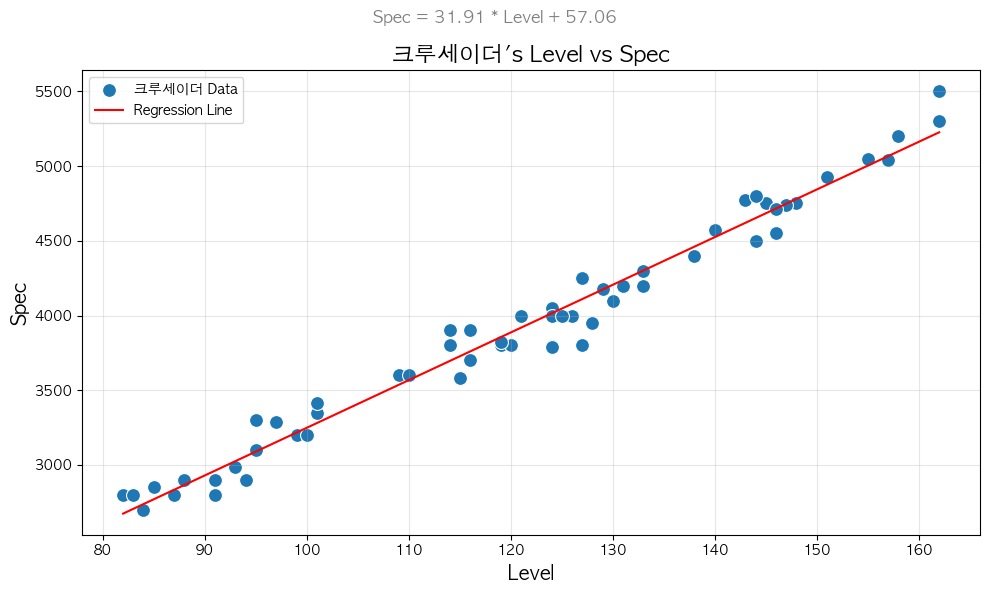

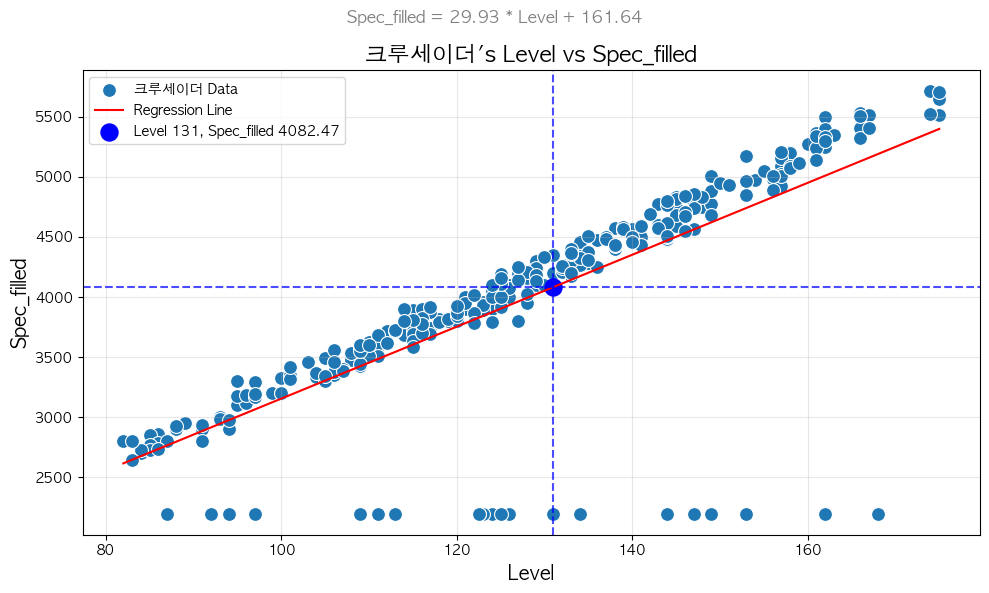

In [5]:
#3 특정 직업, 레벨(optional), 스펙_filled
def plot_level_spec_with_regression(df, job, input_level=None, use_spec_filled=False):
    # Determine the spec column to use
    spec_column = "spec_filled" if use_spec_filled else "spec"

    # Filter for the specific job and drop rows with missing data
    job_df = df[df["job"] == job].dropna(subset=["level", spec_column])
    
    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {job}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df[spec_column].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Regression equation
    equation = f"{spec_column.capitalize()} = {coef:.2f} * Level + {intercept:.2f}"
    
    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y=spec_column, s=100, label=f"{job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    
    # Mark the input level if provided
    if input_level is not None:
        predicted_spec = coef * input_level + intercept
        plt.scatter([input_level], [predicted_spec], color="blue", s=150, label=f"Level {input_level}, {spec_column.capitalize()} {predicted_spec:.2f}")
        plt.axvline(x=input_level, color="blue", linestyle="--", alpha=0.7)
        plt.axhline(y=predicted_spec, color="blue", linestyle="--", alpha=0.7)
    
    # Customize plot
    plt.title(f"{job}'s Level vs {spec_column.capitalize()}", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel(spec_column.capitalize(), fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_level_spec_with_regression(df, "크루세이더")
# plot_level_spec_with_regression(df, "크루세이더", input_level=131, use_spec_filled=True)

In [57]:
#4 레벨+-5의 스펙 회귀
def plot_level_spec_with_regression_by_level(df, job, input_level):
    # Filter data for the specific job and level range (±5)
    job_df = df[(df["job"] == job) & 
                (df["level"] >= input_level - 5) & 
                (df["level"] <= input_level + 5)].dropna(subset=["level", "spec"])

    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {job} and level {input_level}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_

    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"

    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{job}'s Level vs Spec (Level {input_level} ± 5)", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# plot_level_spec_with_regression_by_level(df, "허밋", 130)

In [58]:
#5 특정 직업의 레벨 별 맵 분포
def plot_level_by_map_by_job(df, job):
    # Filter data for the specified job
    job_df = df[df["job"] == job]

    # Calculate map usage percentages
    map_counts = job_df["map"].value_counts(normalize=True)  # Normalize=True gives percentages
    valid_maps = map_counts[map_counts >= 0.05].index  # Keep maps with 5% or more usage

    # Filter job_df to include only valid maps
    filtered_job_df = job_df[job_df["map"].isin(valid_maps)]

    if filtered_job_df.empty:
        print(f"No maps with >=5% usage for job: {job}")
        return

    # Plot the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_job_df, x="map", y="level", palette="Set2")
    plt.title(f"{job} 레벨별 맵 (5% 이상 사용된 맵)")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# plot_level_by_map_by_job(df, "썬콜")

In [68]:
#6 특정직업의 레벨별 사냥터 분포(5%+)
def plot_level_distribution_by_job_and_map(df, job):
    # Filter data for the input job
    filtered_df = df[df["job"] == job]

    if filtered_df.empty:
        print(f"No data found for job '{job}'.")
        return

    # Calculate map usage percentages
    map_counts = filtered_df["map"].value_counts(normalize=True) * 100
    maps_to_include = map_counts[map_counts >= 5].index  # Maps with 5% or more usage

    # Filter data for maps meeting the threshold
    filtered_df = filtered_df[filtered_df["map"].isin(maps_to_include)]

    if filtered_df.empty:
        print(f"No maps with >=5% usage found for job '{job}'.")
        return

    # Plot trendy violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        data=filtered_df,
        x="map",
        y="level",
        palette="husl",
        scale="width",
        inner="quartile"
    )

    # Add titles and labels
    plt.title(f"Level Distribution for '{job}' (Maps with ≥5% Usage)", fontsize=16)
    plt.xlabel("Map", fontsize=14)
    plt.ylabel("Level", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

# plot_level_distribution_by_job_and_map(df, "허밋")

In [67]:
#7 특정 직업의 레벨별 맵 히트맵
def plot_map_level_heatmap_for_job(df, job):
    # Filter data for the selected job
    filtered_df = df[df["job"] == job]

    if filtered_df.empty:
        print(f"No data found for job '{job}'.")
        return

    # Calculate total counts for all maps
    map_usage = filtered_df["map"].value_counts(normalize=True)  # Normalized usage (percentage)
    
    # Keep only maps with 5% or higher usage
    valid_maps = map_usage[map_usage >= 0.05].index
    filtered_df = filtered_df[filtered_df["map"].isin(valid_maps)]

    # If no maps meet the threshold
    if filtered_df.empty:
        print(f"No maps with >= 5% usage for job '{job}'.")
        return

    # Group data by 'map' and 'level', and count occurrences
    map_level_counts = filtered_df.groupby(["map", "level"]).size().reset_index(name="count")
    
    # Pivot the table to have maps as rows and levels as columns
    map_level_pivot = map_level_counts.pivot(index="map", columns="level", values="count").fillna(0)

    # Plot the heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        map_level_pivot, 
        annot=True, 
        fmt=".0f", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Frequency'}
    )
    plt.title(f"Map-Level Distribution for {job} (Maps ≥ 5% Usage)", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Map", fontsize=14)
    plt.tight_layout()
    plt.show()

# plot_map_level_heatmap_for_job(df, "허밋")

In [69]:
#8 특정직업의 레벨 범위별 사냥터 히트맵 
def plot_map_frequency_by_level_range(df, job):
    # Filter for the selected job
    job_df = df[df['job'] == job]
    job_df['level_bin'] = pd.cut(job_df['level'], bins=range(80, 201, 10), right=False)

    # Count maps per level range
    map_frequency = pd.crosstab(job_df['level_bin'], job_df['map'])

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(map_frequency, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title(f"Map Frequency by Level Range for {job}")
    plt.xlabel("Map")
    plt.ylabel("Level Range")
    plt.tight_layout()
    plt.show()
    
# plot_map_frequency_by_level_range(df, "허밋")

In [59]:
#9 맵별 스펙 기재 여부
def visualize_spec_validity_by_map(df, job='all'):
    # Filter for a specific job if provided
    if job.lower() != 'all':
        df = df[df['job'] == job]
        if df.empty:
            print(f"No data available for job '{job}'.")
            return

    # Count valid and invalid entries for each map
    spec_validity_by_map = df.groupby(['map', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    spec_validity_by_map = spec_validity_by_map.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[0], label='미기재', color='#FF6F61')
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[1], bottom=spec_validity_by_map[0], label='기재', color='#6B8E23')

    # Customize plot
    title = f"맵별 스공기재여부 ({job})" if job.lower() != 'all' else "맵별 스공기재여부"
    plt.title(title, fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='맵별 스공 기재 여부', fontsize=12)
    plt.tight_layout()
    plt.show()
# visualize_spec_validity_by_map(df, job='all')
# visualize_spec_validity_by_map(df, job="허밋")

In [60]:
#10 직업별 스펙 기재 여부, job optional
def visualize_spec_validity_by_jobs(df, jobs=None):
    # Filter for specific jobs if provided
    if jobs:
        df = df[df['job'].isin(jobs)]
        if df.empty:
            print(f"No data available for the selected jobs: {jobs}.")
            return

    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    validity_by_job = validity_by_job.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='미기재', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='기재', color='#6B8E23')

    # Customize plot
    title = f"스공기재여부 ({', '.join(jobs)})" if jobs else "직업별 스공기재여부"
    plt.title(title, fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_spec_validity_by_jobs(df)
# visualize_spec_validity_by_jobs(df, ["썬콜", "프리스트"])

In [61]:
#11 날짜별 맵 사용 비율
def visualize_map_distribution_by_date(df):
    """
    Visualizes normalized map distribution by date as a stacked bar chart with diverse colors.
    """
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Normalize counts to percentages
    map_distribution_percentage = map_counts.div(map_counts.sum(axis=1), axis=0) * 100

    # Generate a colormap with as many distinct colors as maps
    num_maps = map_distribution_percentage.shape[1]
    colormap = cm.get_cmap('tab20', num_maps)  # Use 'tab20' or any other diverse colormap
    colors = [mcolors.to_hex(colormap(i)) for i in range(num_maps)]

    # Plot stacked bar chart
    map_distribution_percentage.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Normalized Map Distribution by Date', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Map', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
# visualize_map_distribution_by_date(df)

In [62]:
#12 직업별 레벨(범위 설정 가능)당 스펙
def visualize_level_spec_comparison(df, jobs=None, start_level=None, end_level=None):
    # Use all unique jobs if no specific jobs are provided
    if jobs is None:
        jobs = df['job'].unique().tolist()

    # Filter data for the selected jobs
    job_data = df[df['job'].isin(jobs)].copy()

    # Apply level range filtering if provided
    if start_level is not None:
        job_data = job_data[job_data['level'] >= start_level]
    if end_level is not None:
        job_data = job_data[job_data['level'] <= end_level]

    # Ensure level and spec are numeric
    job_data['level'] = pd.to_numeric(job_data['level'], errors='coerce')
    job_data['spec'] = pd.to_numeric(job_data['spec'], errors='coerce')

    # Drop rows with missing or invalid level/spec values
    job_data = job_data.dropna(subset=['level', 'spec'])

    # Check if there is any data to plot
    if job_data.empty:
        print(f"No data available for the specified criteria.")
        return

    # Dynamically generate colors for the jobs
    color_palette = sns.color_palette("husl", len(jobs))
    colors = {job: color for job, color in zip(jobs, color_palette)}

    plt.figure(figsize=(12, 8))

    # Scatter plot with hue for different jobs
    sns.scatterplot(data=job_data, x='level', y='spec', hue='job', style='job', s=100, alpha=0.6, palette=colors)

    # Add regression lines for each job
    for job in jobs:
        job_specific_data = job_data[job_data['job'] == job]
        if not job_specific_data.empty:
            x = job_specific_data['level'].values.reshape(-1, 1)
            y = job_specific_data['spec'].values
            if len(x) > 1:  # Ensure there are enough points for regression
                model = LinearRegression()
                model.fit(x, y)
                coef = model.coef_[0]
                intercept = model.intercept_
                sns.lineplot(x=job_specific_data['level'], y=model.predict(x), color=colors[job], label=f'{job} Trend')
                # Add regression equation as text
                plt.text(
                    0.05, 0.9 - jobs.index(job) * 0.05,
                    f'{job}: Spec = {coef:.2f} * Level + {intercept:.2f}',
                    transform=plt.gca().transAxes,
                    fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.7)
                )

    # Customize plot appearance
    level_range = f" (Levels: {start_level} - {end_level})" if start_level or end_level else ""
    plt.title(f'Level vs. Spec Comparison for Selected Jobs{level_range}', fontsize=16)
    plt.xlabel('Level', fontsize=14)
    plt.ylabel('Spec', fontsize=14)
    plt.legend(title='Job', fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example Usage
# Specific jobs with a level range
# visualize_level_spec_comparison(df, jobs=["썬콜", "프리스트"], start_level=120, end_level=150)

In [63]:
#13 직업별 레벨에 따른 스공과 맵, 회귀
def plot_combined_scatter_with_regression(df, start_level=None, end_level=None, maps=None):
    # Filter by level range if provided
    if start_level is not None:
        df = df[df["level"] >= start_level]
    if end_level is not None:
        df = df[df["level"] <= end_level]

    # Filter by maps if provided
    if maps:
        df = df[df["map"].isin(maps)]

    if df.empty:
        print("No data available for the specified criteria.")
        return

    # Ensure level and spec are numeric
    df["level"] = pd.to_numeric(df["level"], errors="coerce")
    df["spec"] = pd.to_numeric(df["spec"], errors="coerce")

    # Drop rows with missing or invalid level/spec values
    df = df.dropna(subset=["level", "spec"])

    # Get unique jobs and their corresponding colors
    unique_jobs = df["job"].unique()
    color_palette = sns.color_palette("husl", len(unique_jobs))
    job_colors = {job: color for job, color in zip(unique_jobs, color_palette)}

    # Plot scatterplot
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df,
        x="level",
        y="spec",
        hue="job",
        style="map",  # Different marker styles for maps
        palette=job_colors,
        s=100,
        alpha=0.6,
        edgecolor="w"
    )

    # Add regression lines per job
    for job in unique_jobs:
        job_data = df[df["job"] == job]
        x = job_data["level"].values.reshape(-1, 1)
        y = job_data["spec"].values

        if len(x) > 1:  # Ensure sufficient data points for regression
            model = LinearRegression()
            model.fit(x, y)
            coef = model.coef_[0]
            intercept = model.intercept_
            
            # Match the regression line color to the scatterplot
            plt.plot(
                x.flatten(),
                model.predict(x),
                color=job_colors[job],
                label=f"{job} Trend (y={coef:.2f}x + {intercept:.2f})",
                linewidth=2
            )

    # Customize plot appearance
    level_range = f" (Levels: {start_level} - {end_level})" if start_level or end_level else ""
    plt.title(f"Combined Scatter and Regression{level_range}", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Job and Map", fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()

In [64]:
#14 맵 사용빈도 변화 추이
def visualize_map_percentage_change(df, map):
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Calculate the percentage contribution of each map per date
    map_percentage = map_counts.div(map_counts.sum(axis=1), axis=0) * 100

    # Extract the percentage values for the specific map
    if map not in map_percentage.columns:
        print(f"Map '{map}' not found in the data.")
        return
    
    map_data = map_percentage[map]

    # Plot the percentage change over time
    plt.figure(figsize=(10, 6))
    map_data.plot(kind='line', marker='o', label=f"{map} Distribution %")
    plt.title(f"Percentage Change in {map} Distribution Over Time", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [65]:
#15 특정 직업의 맵 레벨과 스펙에 따른 분포도
def plot_level_spec_distribution_of_job_and_map(df, map, job, use_spec_filled=False):
    # 필터링: 선택된 맵과 직업에 해당하는 데이터만 가져오기
    filtered_df = df[(df['map'] == map) & (df['job'] == job)]

    if filtered_df.empty:
        print(f"No data found for map '{map}' and job '{job}'.")
        return

    # 레벨과 선택된 스펙 컬럼을 숫자로 변환
    spec_column = "spec_filled" if use_spec_filled else "spec"
    filtered_df['level'] = pd.to_numeric(filtered_df['level'], errors='coerce')
    filtered_df[spec_column] = pd.to_numeric(filtered_df[spec_column], errors='coerce')

    # 유효한 데이터만 사용
    filtered_df = filtered_df.dropna(subset=['level', spec_column])

    # 시각화
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=filtered_df,
        x='level',
        y=spec_column,
        s=100,
        alpha=0.6,
        edgecolor='w',
        color='blue'
    )
    
    # 레벨 및 스펙의 밀도 분포를 추가
    sns.kdeplot(
        data=filtered_df,
        x='level',
        y=spec_column,
        cmap='Blues',
        fill=True,
        alpha=0.5
    )

    # 그래프 제목과 레이블 설정
    spec_label = "Spec (Filled)" if use_spec_filled else "Spec"
    plt.title(f"Level and {spec_label} Distribution for {job} on {map}", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel(spec_label, fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# Example Usage
# plot_level_spec_distribution_of_job_and_map(df, "망용둥", "허밋")
# plot_level_spec_distribution_of_job_and_map(df, "망용둥", "허밋", use_spec_filled=True)

In [71]:
#16 특정 직업의 맵별분포와 레벨, 스펙 회귀
def plot_level_spec_distribution_of_job(df, job, use_spec_filled=False):
    # Filter data for the selected job
    filtered_df = df[df['job'] == job]

    if filtered_df.empty:
        print(f"No data found for job '{job}'.")
        return

    # Convert level to numeric
    filtered_df['level'] = pd.to_numeric(filtered_df['level'], errors='coerce')

    # Use spec_filled instead of spec if use_spec_filled is True
    spec_column = 'spec_filled' if use_spec_filled else 'spec'
    filtered_df[spec_column] = pd.to_numeric(filtered_df[spec_column], errors='coerce')

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=['level', spec_column])

    # Calculate map usage percentages and filter maps with >= 5% usage
    map_counts = filtered_df['map'].value_counts(normalize=True)
    valid_maps = map_counts[map_counts >= 0.05].index
    filtered_df = filtered_df[filtered_df['map'].isin(valid_maps)]

    if filtered_df.empty:
        print(f"No maps with >=5% usage for job '{job}'.")
        return

    # Extract unique maps and generate a color palette
    unique_maps = filtered_df['map'].unique()
    map_palette = sns.color_palette("husl", len(unique_maps))
    map_colors = dict(zip(unique_maps, map_palette))  # Map names to colors

    # Plot settings
    plt.figure(figsize=(14, 10))

    # Plot scatter and regression lines for each valid map
    for map, color in map_colors.items():
        map_data = filtered_df[filtered_df['map'] == map]
        
        # Scatter plot
        sns.scatterplot(
            data=map_data,
            x="level",
            y=spec_column,
            color=color,
            label=map,
            s=100,
            alpha=0.7,
            edgecolor="w"
        )

        # Regression line (only if sufficient data points exist)
        if len(map_data) > 1:
            x = map_data['level'].values.reshape(-1, 1)
            y = map_data[spec_column].values

            # Fit linear regression model
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)

            # Add regression line
            plt.plot(
                x,
                y_pred,
                color=color,
                linestyle='--',
                label=f"{map} Trend (y={model.coef_[0]:.2f}x + {model.intercept_:.2f})"
            )

    # Add labels and title
    plt.title(f"Level and Spec Distribution with Map Regression for {job} (5%+ Maps)", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec" if not use_spec_filled else "Spec Filled", fontsize=14)
    plt.legend(title="Map & Regression", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
# plot_level_spec_distribution_of_job(df, "허밋", use_spec_filled=True)
# plot_level_spec_distribution_of_job(df, "허밋")